In [2]:
#hide
! [ -e /content ] && pip install -Uqq fastbook  
# see if there's a directory called /content (no ,there isn't
# this exist for colab, colab uses pip, and uses an older version of fastai
import fastbook
fastbook.setup_book()

To install:

- mamba install -c fastchan fastbook


In [3]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Under the Hood: Training a Digit Classifier

## Pixels: The Foundations of Computer Vision

## Sidebar: Tenacity and Deep Learning

## End sidebar

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
#hide
Path.BASE_PATH = path

In [ ]:
path.ls()

In [ ]:
(path/'train').ls()

In [ ]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

In [ ]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [ ]:
array(im3)[4:10,4:10]

In [ ]:
tensor(im3)[4:10,4:10]

In [ ]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

## First Try: Pixel Similarity

In [ ]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

In [ ]:
show_image(three_tensors[1]);

In [ ]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

In [ ]:
len(stacked_threes.shape)

In [ ]:
stacked_threes.ndim

In [ ]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

In [ ]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

In [ ]:
a_3 = stacked_threes[1]
show_image(a_3);

In [ ]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

In [ ]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

In [ ]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

### NumPy Arrays and PyTorch Tensors

In [ ]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [ ]:
arr  # numpy

In [ ]:
tns  # pytorch

In [ ]:
tns[1]

In [ ]:
tns[:,1]

In [ ]:
tns[1,1:3]

In [ ]:
tns+1

In [ ]:
tns.type()

In [ ]:
tns*1.5

## Computing Metrics Using Broadcasting

In [ ]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

In [ ]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

In [ ]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

In [ ]:
tensor([1,2,3]) + tensor(1)

In [ ]:
(valid_3_tens-mean3).shape

In [ ]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [ ]:
is_3(a_3), is_3(a_3).float()

In [ ]:
is_3(valid_3_tens)

In [ ]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

## Stochastic Gradient Descent (SGD)

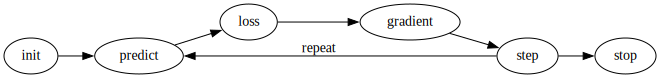

In [38]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [39]:
def f(x): return x**2  # this is our loss function; loss is a function of the weight x

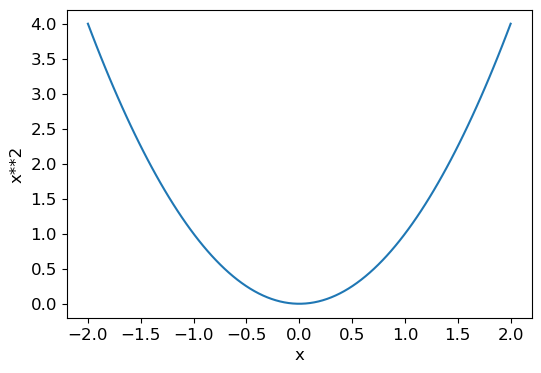

In [40]:
plot_function(f, 'x', 'x**2')

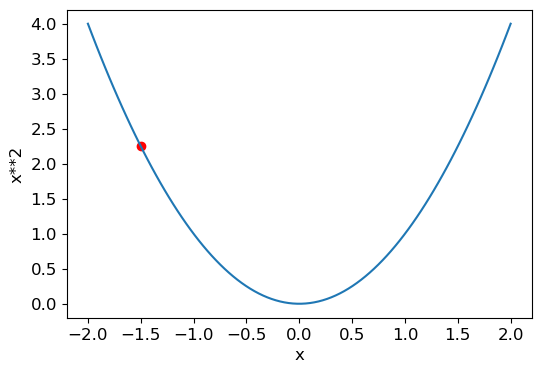

In [41]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');  # step 1 initialize the weight to -1.5 and calculate the loss (red dot)

### Calculating Gradients

In [42]:
xt = tensor(3.).requires_grad_()  # the parameter x (weight) is 3 and we want gradient/slope at 3

In [43]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [44]:
yt.backward()  # calculate gradient at 3/9

In [45]:
xt.grad  # show the gradient at 3; the gradient is derivate of x**2 = 2*x = 2*3

tensor(6.)

In [46]:
xt = tensor([3.,4.,10.]).requires_grad_()  # a more complicated loss function with 3 weights instead of 1
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [47]:
def f(x): return (x**2).sum()  # the loss returns a scalar; why scalar and not a vector/tensor-1 as the input x?

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [48]:
yt.backward()  # calculate gradients
xt.grad

tensor([ 6.,  8., 20.])

### Stepping With a Learning Rate

### An End-to-End SGD Example

In [49]:
time = torch.arange(0,20).float();  # a tensor with 20 time intervals from 0 to 19
time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

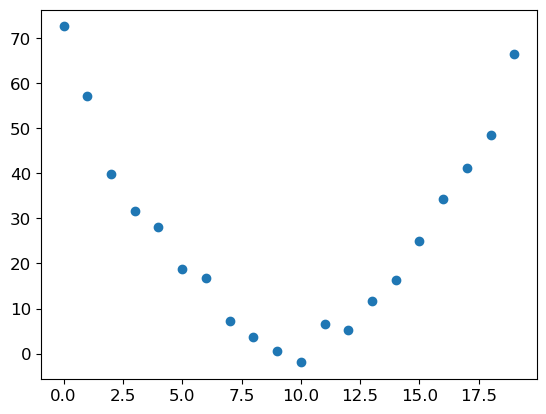

In [50]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1  # speed are some values for speed that were supposedly measured every 20s
plt.scatter(time,speed);                            # they are recorded data, target data

In [51]:
def f(t, params):                     # f is a function that aim to match the points above; we guess it's quadratic
    a,b,c = params                    # input is time and parameters are a,b,c
    return a*(t**2) + (b*t) + c       

In [52]:
def mse(preds, targets): return ((preds-targets)**2).mean()  # define the loss function, the mse between predictions and targets

#### Step 1: Initialize the parameters

In [53]:
params = torch.randn(3).requires_grad_()  # initialize the parameters with some random values; the params the the a,b,c of the quadratic function we want to find

In [54]:
#hide
orig_params = params.clone()

#### Step 2: Calculate the predictions

In [55]:
preds = f(time, params)  # calculate the prediction of the quadratic f with the random params

In [56]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

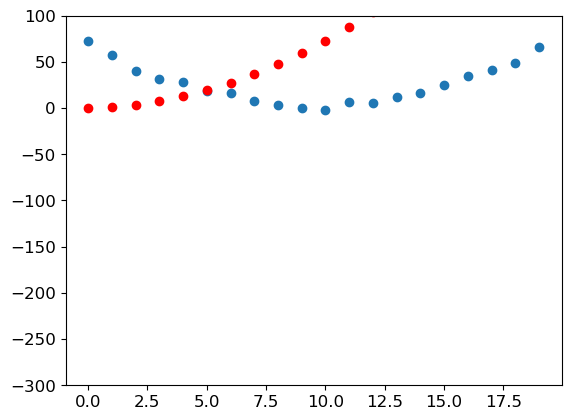

In [57]:
show_preds(preds)  # show predictions (red) with 1st choice of random parameters (params)

#### Step 3: Calculate the loss

In [58]:
loss = mse(preds, speed)  # the loss is mse between predictions and measured speed
loss

tensor(10187.9268, grad_fn=<MeanBackward0>)

#### Step 4: Calculate the gradients

In [59]:
loss.backward()  # calculate gradients by derivating the loss function; find each gradient by derivating each ax**2 and keeping the rest as a constant
params.grad      # gradients are "attached" to params because it shows in which direction to change the params a,b,c  

tensor([32728.7188,  2100.9204,   124.9925])

In [60]:
params.grad * 1e-5  # adjust the gradients: -53k * 0.00001 = 0.5320

tensor([0.3273, 0.0210, 0.0012])

In [61]:
params  # these are the parameters before being adjusted with the learning rate

tensor([ 0.6863,  0.4679, -0.2049], requires_grad=True)

In [62]:
#params.data # is the same as params
#params.grad.data  #  

#### Step 5: Step the weights. 

In [63]:
# w -=gradient(w)*lr
# adjusts the parameter in the direction of the slope (gradient)
# increasing the parameter when the slope (gradient) is negative and decreasing the parameter when the slope is positive
lr = 1e-5
params.data -= lr * params.grad.data  # how to change our parameters based on the values of the gradients	                            
params.grad = None                    # multiplying the gradient by some small number, called the learning rate (LR)

In [64]:
preds = f(time,params)  # new predictions based on quadratic f with new parameters
mse(preds, speed)       # new loss

tensor(2470.4714, grad_fn=<MeanBackward0>)

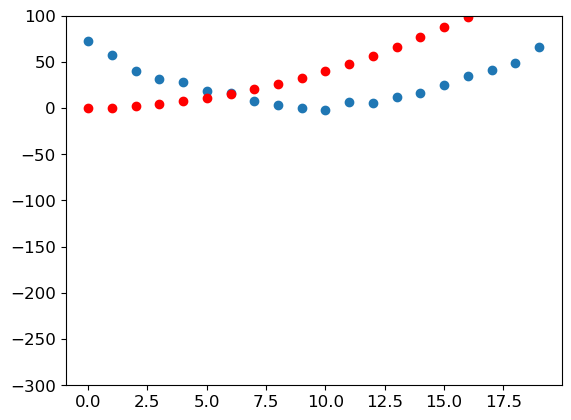

In [65]:
show_preds(preds)

In [66]:
params  # added by me

tensor([ 0.3590,  0.4469, -0.2062], requires_grad=True)

In [68]:
def apply_step(params, prn=True):  # all the above steps
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

In [70]:
for i in range(10): apply_step(params)  # iterate 10 times and see the loss going down

669.2116088867188
669.2081298828125
669.2045288085938
669.2009887695312
669.1973876953125
669.19384765625
669.1903686523438
669.1868286132812
669.1832885742188
669.1797485351562


In [76]:
#hide
params = orig_params.detach().requires_grad_()  # what is this?

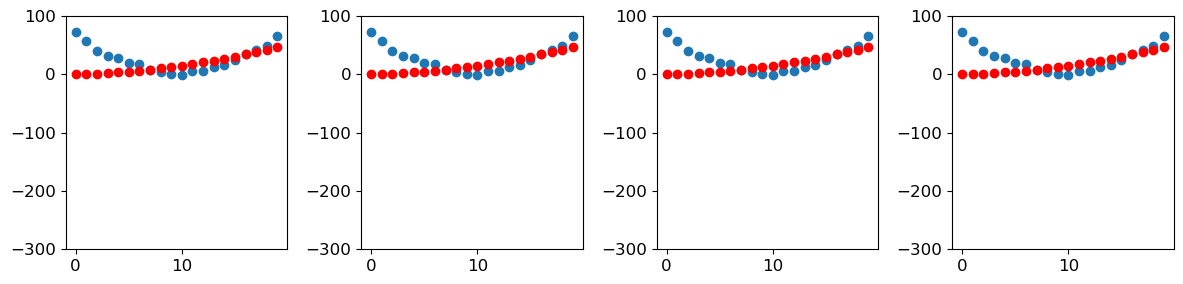

In [79]:
_,axs = plt.subplots(1,4,figsize=(12,3))                 # instead of printing the loss, we plot the quadratic at every step
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

### Summarizing Gradient Descent

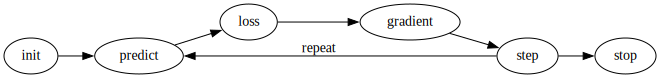

In [75]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

## The MNIST Loss Function

In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [ ]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

In [ ]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

In [ ]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [ ]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [ ]:
weights = init_params((28*28,1))

In [ ]:
bias = init_params(1)

In [ ]:
(train_x[0]*weights.T).sum() + bias

In [ ]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

In [ ]:
corrects = (preds>0.0).float() == train_y
corrects

In [ ]:
corrects.float().mean().item()

In [ ]:
with torch.no_grad(): weights[0] *= 1.0001

In [ ]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

In [ ]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [ ]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [ ]:
torch.where(trgts==1, 1-prds, prds)

In [ ]:
mnist_loss(prds,trgts)

In [ ]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

### Sigmoid

In [ ]:
def sigmoid(x): return 1/(1+torch.exp(-x))

In [ ]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [ ]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD and Mini-Batches

In [ ]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

In [ ]:
ds = L(enumerate(string.ascii_lowercase))
ds

In [ ]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

## Putting It All Together

In [ ]:
weights = init_params((28*28,1))
bias = init_params(1)

In [ ]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

In [ ]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [ ]:
batch = train_x[:4]
batch.shape

In [ ]:
preds = linear1(batch)
preds

In [ ]:
loss = mnist_loss(preds, train_y[:4])
loss

In [ ]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

In [ ]:
weights.grad.zero_()
bias.grad.zero_();

In [ ]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [ ]:
(preds>0.0).float() == train_y[:4]

In [ ]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [ ]:
batch_accuracy(linear1(batch), train_y[:4])

In [ ]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [ ]:
validate_epoch(linear1)

In [ ]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

In [ ]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

### Creating an Optimizer

In [ ]:
linear_model = nn.Linear(28*28,1)

In [ ]:
w,b = linear_model.parameters()
w.shape,b.shape

In [ ]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [ ]:
opt = BasicOptim(linear_model.parameters(), lr)

In [ ]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [ ]:
validate_epoch(linear_model)

In [ ]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [ ]:
train_model(linear_model, 20)

In [ ]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

In [ ]:
dls = DataLoaders(dl, valid_dl)

In [ ]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
learn.fit(10, lr=lr)

## Adding a Nonlinearity

In [ ]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [ ]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [ ]:
plot_function(F.relu)

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
learn.fit(40, 0.1)

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [ ]:
learn.recorder.values[-1][2]

### Going Deeper

In [ ]:
dls = ImageDataLoaders.from_folder(path)
learn = vision_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

## Jargon Recap

## Questionnaire

1. How is a grayscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.